# Imports 

In [4]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import  MinMaxScaler, StandardScaler 
from xgboost import XGBClassifier
import yaml

# 1. Understanding the data 

Looking at the data we can see 2 types of breast cancer being either malignant or benign. furthermore we see 30 features per sample of breast cancer. 

# 2. Load the data

In [5]:
def get_config():
    with open("../config.yaml", 'r') as stream:
        config = yaml.safe_load(stream)
    return config

In [6]:
config = get_config()
df = pd.read_csv(config['breastcancer'])
df

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


# 3. Exploratory analysis

In [7]:
# there are no nan 
df.isnull().values.any()

False

## LDA 
To look which components maximizes the separation between malignant and benign we are going to use to train the model

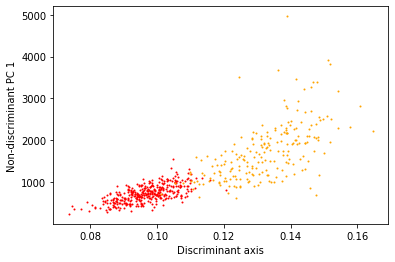

In [8]:
### step 1: devide your data
malignant = np.array(df[df.diagnosis == 'M'].values[:, 2:], dtype=float)
benign = np.array(df[df.diagnosis == 'B'].values[:, 2:], dtype=float)
### step2: calculated the mean and the covariance
mw = malignant.mean(axis=0)
mr = benign.mean(axis=0)

nw = malignant.shape[0]
nr = benign.shape[0]

Sw = np.cov(malignant.T)
Sr = np.cov(benign.T)
### step3: calculated the pooled covariance matrix
Sp = ((nr - 1) * Sr + (nw - 1) * Sw) / (nr + nw - 2)
### step4: project the data onto the discriminant axis
a = np.linalg.inv(Sp) @ (mw - mr)
a /= np.sqrt((a ** 2).sum())

tw = malignant @ a
tr = benign @ a

### step5: deflate both groups, combine and plot the data

Ew = malignant - tw[:, None] * a[None, :]
Er = benign - tr[:, None] * a[None, :]

X = np.concatenate((Ew, Er), axis=0)
S = np.cov(X.T)
vals, vecs = np.linalg.eig(S)
order = vals.argsort()[::-1]
vecs = vecs[:, order]
vals = vals[order]
Tw = malignant @ vecs
Tr = benign @ vecs


plt.scatter(tr, Tr[:, 0], s=1, c="red")
plt.scatter(tw, Tw[:, 0], s=1, c="orange")
plt.xlabel("Discriminant axis")
plt.ylabel("Non-discriminant PC 1")  
plt.show()

In [9]:
separation = [i/sum(vals)*100 for i in vals]
# the first component has 98% of the separation between the two groups
print(separation[:5])
# the first feature is the component that has 98% of the separation
print(order[:5])

[98.20446717546164, 1.6176489875553843, 0.15575107362089877, 0.01209318339365391, 0.008827244953170915]
[0 1 2 3 4]


# 4. Modeling (cross-validation and training)

In [10]:
X = np.array(df.values[:, 2], dtype=float)
X = np.reshape(X, (569,1))
scaler=MinMaxScaler()
X= scaler.fit_transform(X)
y = df.values[:, 1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

An adaBoost classifier is a meta-estimator that begins by fitting a classifier on the original dataset and then fits additional copies of the classifier on the same dataset but where the weights of incorrectly classified instaces are adjusted such that subsequent classifiers focus more on difficult cases
reference: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html

In [11]:
ada = AdaBoostClassifier(random_state=42)
ada.fit(X_train, y_train)

AdaBoostClassifier(random_state=42)

Dummyclassifier makes predictions that ignore the inpute features
reference: https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html

In [17]:
dummy = DummyClassifier(random_state=42)
params = {
    'strategy': ['most_frequent', 'prior', 'stratified', 'uniform']
}
dummy_grid = GridSearchCV(dummy, params)
best_dummy = dummy_grid.fit(X_test, y_test)

# 5. Evaluation
a confussion matrix helps to see how well the models predict a certain class. In the last confusion matrices below the 0 and 1 on both axis means benign and malignant respectively. 
With the adaboost it worked quite well getting 119 out of 121 right and for malignant getting 54 out of 67 right.
The dummy classifier just purely guest benign all the time so 50% was guest correctly.

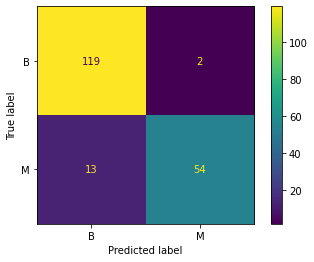

In [13]:
ConfusionMatrixDisplay.from_estimator(ada, X_test, y_test)

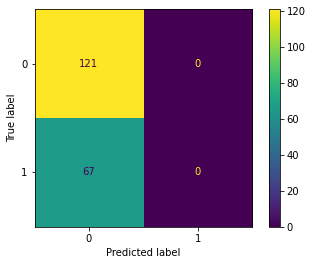

In [18]:
ConfusionMatrixDisplay.from_estimator(best_dummy, X_test, y_test)

The last classifier is XGB which works by training a number of decision trees. each tree is trained on a subset of the data, and the predictions from each tree are combined to form the final prediction.

This classifier performed slightly worse than the adaboost classifier with 105 out of 121 and 46 out of 67 correct gueses.

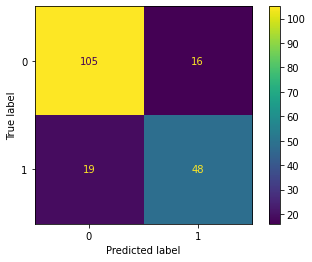

In [15]:
for index, value in enumerate(y):
    if value == 'M':
        y[index] = 1
    if value == 'B':
        y[index] = 0
y = np.array(y, dtype=int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
XGBoost = XGBClassifier()
XGBoost.fit(X_train, y_train)
ConfusionMatrixDisplay.from_estimator(XGBoost, X_test, y_test)